# Abnormality Detection in Musculoskeletal Radiographs

Author: Rajkumar Shanmuganathan

The objective is to build a machine learning model that can detect an abnormality in the X-Ray radiographs. These models can help towards providing healthcare access to the parts of the world where access to skilled radiologists is limited. According to a study on the Global Burden of Disease and the worldwide impact of all diseases found that, “musculoskeletal conditions affect more than 1.7 billion people worldwide. They are the 2nd greatest cause of disabilities, and have the 4th greatest impact on the overall health of the world population when considering both death and disabilities”. (www.usbji.org, n.d.).

This project attempts to implement deep neural network using DenseNet169 inspired from the Stanford Paper Rajpurkar, et al., 2018.

## Phase 4: Ensemble

I am planning to ensemble the models i built in the previous phases for each study types by generating the final output of the ensemble from the average output of all 7 models combined.

In [1]:
from keras.applications.densenet import DenseNet169, DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, image
from keras.models import Sequential, Model, load_model, Input
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Activation, Dropout, Flatten, Dense, average
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
import pandas as pd
from tqdm import tqdm
import os
import numpy as np
import random
from keras.optimizers import Adam
import keras.backend as K
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [16]:
def ensemble(models, model_input):
    # collect outputs of models in a list
    yModels=[model(model_input) for model in models] 
    # averaging outputs
    yAvg=average(yModels) 
    # build model from same input and avg output
    modelEns = Model(inputs=model_input, outputs=yAvg,    name='ensemble')  
   
    return modelEns

In [6]:
models=[]
model_xr_elbow = load_model("densenet_mura_rs_v3_xr_elbow.h5")
model_xr_elbow.name = 'model_xr_elbow'
model_xr_finger = load_model("densenet_mura_rs_v3_xr_finger.h5")
model_xr_finger.name = 'model_xr_finger'
model_xr_forearm = load_model("densenet_mura_rs_v3_xr_forearm.h5")
model_xr_forearm.name = 'model_xr_forearm'
model_xr_hand = load_model("densenet_mura_rs_v3_xr_hand.h5")
model_xr_hand.name = 'model_xr_hand'
model_xr_shoulder = load_model("densenet_mura_rs_v3_xr_shoulder.h5")
model_xr_shoulder.name = 'model_xr_shoulder'
model_xr_wrist = load_model("densenet_mura_rs_v3_xr_wrist.h5")
model_xr_wrist.name = 'model_xr_wrist'
model_xr_humerus = load_model("densenet_mura_rs_v3_xr_humerus.h5")
model_xr_humerus.name = 'model_xr_humerus'

models.append(model_xr_elbow)
models.append(model_xr_finger)
models.append(model_xr_forearm)
models.append(model_xr_hand)
models.append(model_xr_shoulder)
models.append(model_xr_wrist)
models.append(model_xr_humerus)


In [ ]:
model_input = Input(shape=models[0].input_shape[1:]) # c*h*w
modelEns = ensemble(models, model_input)

In [18]:
modelEns.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
model_xr_elbow (Model)          (None, 1)            12644545    input_5[0][0]                    
__________________________________________________________________________________________________
model_xr_finger (Model)         (None, 1)            12644545    input_5[0][0]                    
__________________________________________________________________________________________________
model_xr_forearm (Model)        (None, 1)            12644545    input_5[0][0]                    
__________________________________________________________________________________________________
model_xr_h

In [47]:
modelEns.save("densenet_mura_rs_v3_ensemble.h5")

## 4.1 Evaluation

### 4.1.1 Creating a csv file containing path to image & csv

In [2]:
def create_images_metadata_csv(category,study_types):
    """
    This function creates a csv file containing the path of images, label.
    """
    image_data = {}
    study_label = {'positive': 1, 'negative': 0}
    #study_types = ['XR_ELBOW','XR_FINGER','XR_FOREARM','XR_HAND','XR_HUMERUS','XR_SHOULDER','XR_WRIST']
    #study_types = ['XR_ELBOW']
    i = 0
    image_data[category] = pd.DataFrame(columns=['Path','Count', 'Label'])
    for study_type in study_types: # Iterate throught every study types
        DATA_DIR = 'data/MURA-v1.1/%s/%s/' % (category, study_type)
        patients = list(os.walk(DATA_DIR))[0][1]  # list of patient folder names
        for patient in tqdm(patients):  # for each patient folder
            for study in os.listdir(DATA_DIR + patient):  # for each study in that patient folder
                if(study != '.DS_Store'):
                    label = study_label[study.split('_')[1]]  # get label 0 or 1
                    path = DATA_DIR + patient + '/' + study + '/'  # path to this study
                    for j in range(len(list(listdir_nohidden(path)))):
                        image_path = path + 'image%s.png' % (j + 1)
                        image_data[category].loc[i] = [image_path,1, label]  # add new row
                        i += 1
    image_data[category].to_csv(category+"_image_data.csv",index = None, header=False)

In [3]:
#New function create image array by study level
def getImagesInArrayNew(train_dataframe):
    images = []
    labels = []
    for i, data in tqdm(train_dataframe.iterrows()):
        img = cv2.imread(data['Path'])
#         #random rotation
#         angle = random.randint(-30,30)
#         M = cv2.getRotationMatrix2D((img_width/2,img_height/2),angle,1)
#         img = cv2.warpAffine(img,M,(img_width,img_height))
        #resize
        img = cv2.resize(img,(img_width,img_height))    
        img = img[...,::-1].astype(np.float32)
        images.append(img)
        labels.append(data['Label'])
    images = np.asarray(images).astype('float32') 
    #normalization
    mean = np.mean(images[:, :, :])
    std = np.std(images[:, :, :])
    images[:, :, :] = (images[:, :, :] - mean) / std
    labels = np.asarray(labels)
    return {'images': images, 'labels': labels}

In [4]:
img_width, img_height = 224, 224
#Keras ImageDataGenerator to load, transform the images of the dataset
BASE_DATA_DIR = 'data/'
IMG_DATA_DIR = 'MURA-v1.1/'

In [5]:
#Utility function to find the list of files in a directory excluding the hidden files.
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [6]:
modelEns = load_model("densenet_mura_rs_v3_ensemble.h5")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## XR_FOREARM

In [65]:
valid_data_dir = BASE_DATA_DIR + IMG_DATA_DIR + 'valid/XR_FOREARM'

test_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True

)

study_types = ['XR_FOREARM']

create_images_metadata_csv('valid',study_types)

valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label'])

dd={}

dd['valid'] = valid_image_df

valid_dict = getImagesInArrayNew(valid_image_df)

test_datagen.fit(valid_dict['images'],augment=True)

validation_generator = test_datagen.flow(
    x=valid_dict['images'],
    y=valid_dict['labels'],
    batch_size = 1
)


100%|██████████| 129/129 [00:00<00:00, 184.97it/s]
301it [00:01, 241.09it/s]


### 4.1.2 Performance Evaluation of XR_FOREARM

In [66]:
#model parameters for training
#K.set_learning_phase(1)
nb_validation_samples = len(valid_dict['images'][:300])
epochs = 10
batch_size = 8
n_classes = 1
#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
validation_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = modelEns.predict_on_batch(valid_dict['images'][:300])

predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]

error = np.sum(np.not_equal(predictions, valid_dict['labels'][:300])) / valid_dict['labels'][:300].shape[0]  
pred = predictions

In [67]:
error

0.25666666666666665

In [70]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
cohen_kappa_score(valid_dict['labels'][:300], pred)

0.4866666666666667

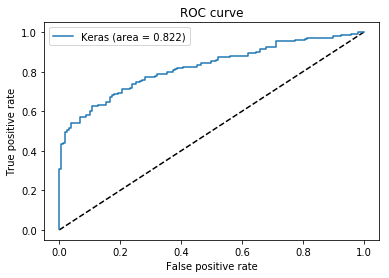

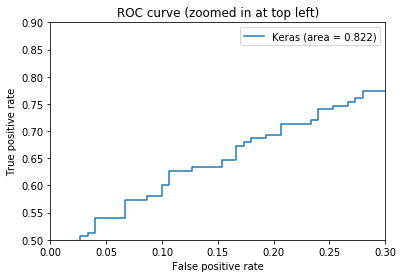

In [71]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_dict['labels'][:300], pred_batch)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.3)
plt.ylim(0.5, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [72]:
print()
print('Classification Report')
print(classification_report(valid_dict['labels'][:300], pred, target_names=["0","1"]))


Classification Report
             precision    recall  f1-score   support

          0       0.70      0.85      0.77       150
          1       0.81      0.63      0.71       150

avg / total       0.76      0.74      0.74       300



## XR_ELBOW

In [73]:
valid_data_dir = BASE_DATA_DIR + IMG_DATA_DIR + 'valid/XR_ELBOW'

test_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True

)

study_types = ['XR_ELBOW']

create_images_metadata_csv('valid',study_types)

valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label'])

dd={}

dd['valid'] = valid_image_df

valid_dict = getImagesInArrayNew(valid_image_df)

test_datagen.fit(valid_dict['images'],augment=True)

validation_generator = test_datagen.flow(
    x=valid_dict['images'],
    y=valid_dict['labels'],
    batch_size = 1
)


100%|██████████| 152/152 [00:01<00:00, 139.45it/s]
465it [00:01, 250.34it/s]


### 4.1.2 Performance Evaluation of XR_ELBOW

In [74]:
#model parameters for training
#K.set_learning_phase(1)
nb_validation_samples = len(valid_dict['images'][:300])
epochs = 10
batch_size = 8
n_classes = 1
#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
validation_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = modelEns.predict_on_batch(valid_dict['images'][:300])

predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]

error = np.sum(np.not_equal(predictions, valid_dict['labels'][:300])) / valid_dict['labels'][:300].shape[0]  
pred = predictions

In [75]:
error

0.20333333333333334

In [77]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
cohen_kappa_score(valid_dict['labels'][:300], pred)

0.5935501066098081

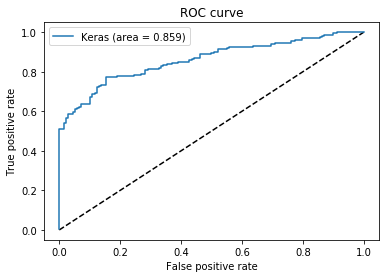

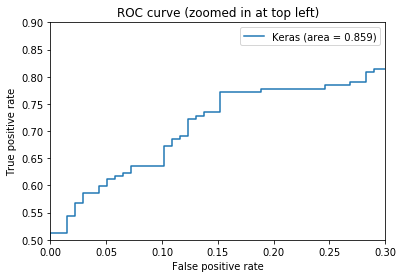

In [78]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_dict['labels'][:300], pred_batch)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.3)
plt.ylim(0.5, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [79]:
print()
print('Classification Report')
print(classification_report(valid_dict['labels'][:300], pred, target_names=["0","1"]))


Classification Report
             precision    recall  f1-score   support

          0       0.75      0.83      0.79       138
          1       0.84      0.77      0.80       162

avg / total       0.80      0.80      0.80       300



## XR_WRIST

In [33]:
valid_data_dir = BASE_DATA_DIR + IMG_DATA_DIR + 'valid/XR_WRIST'

test_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True

)

study_types = ['XR_WRIST']

create_images_metadata_csv('valid',study_types)

valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label'])

dd={}

dd['valid'] = valid_image_df

valid_dict = getImagesInArrayNew(valid_image_df)

test_datagen.fit(valid_dict['images'],augment=True)

validation_generator = test_datagen.flow(
    x=valid_dict['images'],
    y=valid_dict['labels'],
    batch_size = 1
)


100%|██████████| 207/207 [00:01<00:00, 134.40it/s]
659it [00:02, 255.99it/s]


### 4.1.2 Performance Evaluation of XR_WRIST

In [38]:
#model parameters for training
#K.set_learning_phase(1)
nb_validation_samples = len(valid_dict['images'][:300])
epochs = 10
batch_size = 8
n_classes = 1
#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
validation_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = modelEns.predict_on_batch(valid_dict['images'][:300])

predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]

error = np.sum(np.not_equal(predictions, valid_dict['labels'][:300])) / valid_dict['labels'][:300].shape[0]  
pred = predictions

In [39]:
error

0.24666666666666667

In [40]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
cohen_kappa_score(valid_dict['labels'][:300], pred)

0.5103445233578896

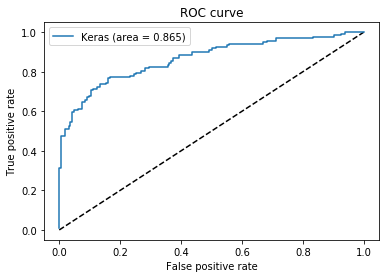

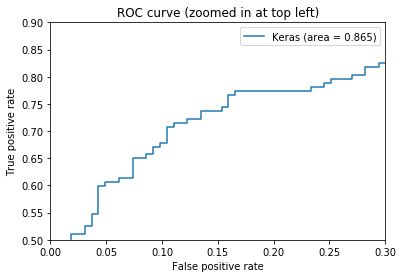

In [42]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_dict['labels'][:300], pred_batch)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.3)
plt.ylim(0.5, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

## XR_HUMERUS

In [43]:
valid_data_dir = BASE_DATA_DIR + IMG_DATA_DIR + 'valid/XR_HUMERUS'

test_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True

)

study_types = ['XR_HUMERUS']

create_images_metadata_csv('valid',study_types)

valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label'])

dd={}

dd['valid'] = valid_image_df

valid_dict = getImagesInArrayNew(valid_image_df)

test_datagen.fit(valid_dict['images'],augment=True)

validation_generator = test_datagen.flow(
    x=valid_dict['images'],
    y=valid_dict['labels'],
    batch_size = 1
)


100%|██████████| 132/132 [00:00<00:00, 198.89it/s]
288it [00:01, 249.26it/s]


### 4.1.2 Performance Evaluation of XR_HUMERUS

In [44]:
#model parameters for training
#K.set_learning_phase(1)
nb_validation_samples = len(valid_dict['images'][:300])
epochs = 10
batch_size = 8
n_classes = 1
#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
validation_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = modelEns.predict_on_batch(valid_dict['images'][:300])

predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]

error = np.sum(np.not_equal(predictions, valid_dict['labels'][:300])) / valid_dict['labels'][:300].shape[0]  
pred = predictions

In [45]:
error

0.2326388888888889

In [46]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
cohen_kappa_score(valid_dict['labels'][:300], pred)

0.5362430301865027

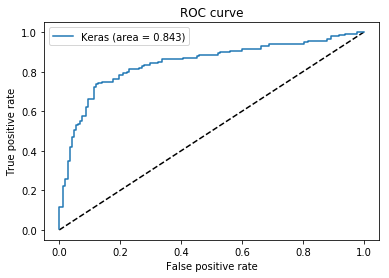

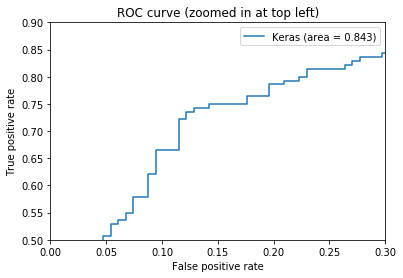

In [47]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_dict['labels'][:300], pred_batch)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.3)
plt.ylim(0.5, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

## XR_FINGER

In [48]:
valid_data_dir = BASE_DATA_DIR + IMG_DATA_DIR + 'valid/XR_FINGER'

test_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True

)

study_types = ['XR_FINGER']

create_images_metadata_csv('valid',study_types)

valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label'])

dd={}

dd['valid'] = valid_image_df

valid_dict = getImagesInArrayNew(valid_image_df)

test_datagen.fit(valid_dict['images'],augment=True)

validation_generator = test_datagen.flow(
    x=valid_dict['images'],
    y=valid_dict['labels'],
    batch_size = 1
)


100%|██████████| 166/166 [00:01<00:00, 155.53it/s]
461it [00:01, 287.88it/s]


### 4.1.2 Performance Evaluation of XR_FINGER

In [49]:
#model parameters for training
#K.set_learning_phase(1)
nb_validation_samples = len(valid_dict['images'][:300])
epochs = 10
batch_size = 8
n_classes = 1
#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
validation_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = modelEns.predict_on_batch(valid_dict['images'][:300])

predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]

error = np.sum(np.not_equal(predictions, valid_dict['labels'][:300])) / valid_dict['labels'][:300].shape[0]  
pred = predictions

In [50]:
error

0.32666666666666666

In [51]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
cohen_kappa_score(valid_dict['labels'][:300], pred)

0.3268306086000825

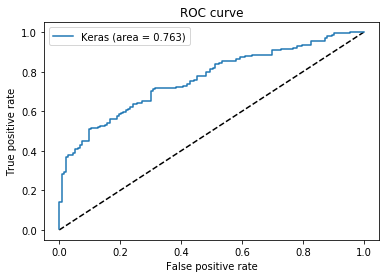

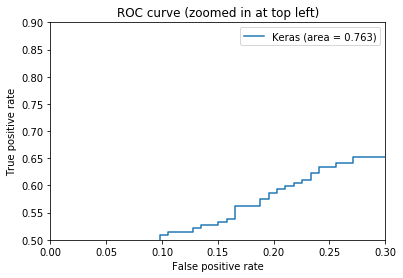

In [52]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_dict['labels'][:300], pred_batch)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.3)
plt.ylim(0.5, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

## XR_HAND

In [80]:
valid_data_dir = BASE_DATA_DIR + IMG_DATA_DIR + 'valid/XR_HAND'

test_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True

)

study_types = ['XR_HAND']

create_images_metadata_csv('valid',study_types)

valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label'])

dd={}

dd['valid'] = valid_image_df

valid_dict = getImagesInArrayNew(valid_image_df)

test_datagen.fit(valid_dict['images'],augment=True)

validation_generator = test_datagen.flow(
    x=valid_dict['images'],
    y=valid_dict['labels'],
    batch_size = 1
)


100%|██████████| 159/159 [00:01<00:00, 147.03it/s]
460it [00:01, 246.70it/s]


### 4.1.2 Performance Evaluation of XR_HAND

In [81]:
#model parameters for training
#K.set_learning_phase(1)
nb_validation_samples = len(valid_dict['images'][:300])
epochs = 10
batch_size = 8
n_classes = 1
#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
validation_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = modelEns.predict_on_batch(valid_dict['images'][:300])

predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]

error = np.sum(np.not_equal(predictions, valid_dict['labels'][:300])) / valid_dict['labels'][:300].shape[0]  
pred = predictions

In [82]:
error

0.3933333333333333

In [83]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
cohen_kappa_score(valid_dict['labels'][:300], pred)

0.15906499429874565

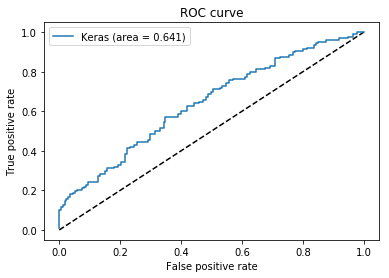

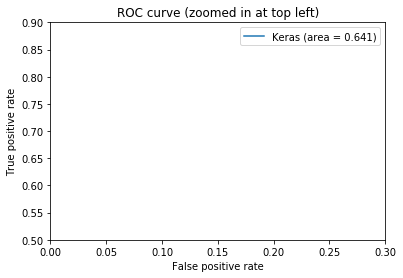

In [57]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_dict['labels'][:300], pred_batch)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.3)
plt.ylim(0.5, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

## XR_SHOULDER

In [60]:
valid_data_dir = BASE_DATA_DIR + IMG_DATA_DIR + 'valid/XR_SHOULDER'

test_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True

)

study_types = ['XR_SHOULDER']

create_images_metadata_csv('valid',study_types)

valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label'])

dd={}

dd['valid'] = valid_image_df

valid_dict = getImagesInArrayNew(valid_image_df)

test_datagen.fit(valid_dict['images'],augment=True)

validation_generator = test_datagen.flow(
    x=valid_dict['images'],
    y=valid_dict['labels'],
    batch_size = 1
)


100%|██████████| 173/173 [00:01<00:00, 132.28it/s]
563it [00:02, 252.68it/s]


### 4.1.2 Performance Evaluation of XR_SHOULDER

In [61]:
#model parameters for training
#K.set_learning_phase(1)
nb_validation_samples = len(valid_dict['images'][:300])
epochs = 10
batch_size = 8
n_classes = 1
#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
validation_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = modelEns.predict_on_batch(valid_dict['images'][:300])

predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]

error = np.sum(np.not_equal(predictions, valid_dict['labels'][:300])) / valid_dict['labels'][:300].shape[0]  
pred = predictions

In [62]:
error

0.43666666666666665

In [63]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
cohen_kappa_score(valid_dict['labels'][:300], pred)

0.13626373626373622

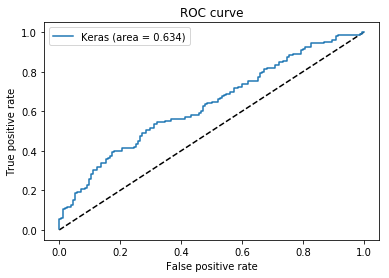

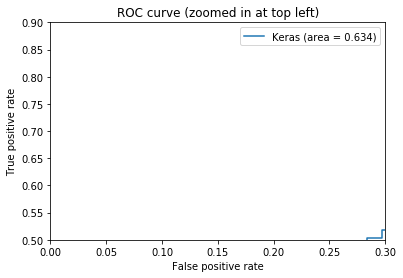

In [64]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_dict['labels'][:300], pred_batch)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.3)
plt.ylim(0.5, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()